# COMP_SCI_7318 - Assignment 3 - Recurrent Neural Networks for Stock Price Prediction
## Walter Rowlands - a1867404

### Trimester 3, 2022

### Import libraries

For this assignment, the following packages were implemented as shown below.

In [1]:
### Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime
import seaborn as sns
import keras
import warnings

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
warnings.filterwarnings('ignore')

### Load dataset

The dataset chosen for this assignment was the 'Stock Market Dataset' available through Kaggle: https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?resource=download. The dataset comprises historical daily prices for all tickers currently traded on the National Association of Securities Dealers and Automated Quotations (NASDAQ), one of the largest stock exchange markets in the world. The historic data is sourced from Yahoo Finance through use of the 'yfinance' package in Python.

The data can either be downloaded to a local machine or imported using the yfinance package. Here, we import the data to the workbook using the yfinance package. The import method was chosen because this allows for data up to 2022 to be utilised, whereas the download available through Kaggle only contains data up to April 2020. The dataset contains information on both individual stocks and Exchange Traded Funds (ETFs) dating as far back as the 1970s in some cases. Data is available for over 5,000 stocks and more than 2,000 ETFs. For this exercise, experiments were conducted only using stock data.

Below, the stock to be analysed is specified using its ticker identity along with start and end dates for the data. The ticker can be readily modified to conduct analysis on different individual stocks. The download is then conducted via yfinance, and we subsequently load the information into a Pandas DataFrame.

In [2]:
### Download data from Yahoo Finance
ticker = 'COKE'
start_date = datetime.datetime(2012, 1, 1)
end_date = datetime.datetime(2022, 1, 1)

stock = []
stock = yf.download(ticker, start = start_date, end = end_date, progress = False)

In [3]:
### Load data into Pandas DataFrame
stock_df = pd.DataFrame()
stock_df = stock_df.append(stock, sort = False)
stock_df['Symbol'] = ticker

stock_df

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2012-01-03,59.189999,59.189999,58.099998,58.599998,53.998177,37200,COKE
2012-01-04,58.400002,58.720001,57.639999,57.669998,53.141216,18500,COKE
2012-01-05,57.740002,58.369999,57.419998,57.779999,53.242561,8500,COKE
2012-01-06,57.759998,58.189999,56.730000,56.730000,52.275036,17400,COKE
2012-01-09,57.520000,57.520000,56.799999,57.139999,52.652832,12200,COKE
...,...,...,...,...,...,...,...
2021-12-27,590.909973,602.140015,585.369995,599.650024,598.463135,21600,COKE
2021-12-28,605.000000,619.150024,605.000000,612.020020,610.808716,23900,COKE
2021-12-29,611.349976,625.000000,602.020020,616.000000,614.780762,19000,COKE


### Data exploration

Below, we explore the nature of the stock chosen for analysis within the Stock Market Dataset. This includes using some common tabulation and visual techniques to gain contextual understanding on the data, as well as viewing the spread, shape, and centre of feature distributions. We also study how the data has changed in time.

We first confirm the size of the chosen dataset. It must be kept in mind that the NASDAQ is inactive during weekends and some public holidays, and therefore data will not be available for each day between our specified start and end dates. Then, we use the Pandas built-in 'info' function to verify there is no null data, all features contain equal counts and to understand our data types. After this, we generate a statistical summary for the features using the Pandas built-in 'describe' function.

The temporal nature of the stock is then assessed. The closing price history is plotted, before producing some moving average curves to understand how the price tends to shift in time. We lastly produce a histogram detailing the distribution of daily return values so we can gain understanding on how much the stock closing price varies day-to-day.

In [4]:
### Print length of dataset
df_len = len(stock_df)
print(f'The dataset contains {df_len} days of data')

The dataset contains 2517 days of data


In [5]:
### Get general information on dataset
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-03 to 2021-12-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
 6   Symbol     2517 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 157.3+ KB


In [6]:
### Produce statistical summary of dataset
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000
mean,179.942511,182.607398,177.407775,180.006150,176.722397,38859.833135
std,104.458498,106.417956,102.819181,104.622585,105.310228,41088.652697
min,56.740002,57.520000,56.509998,56.730000,52.275036,2700.000000
25%,76.250000,77.000000,75.510002,76.230003,73.046379,17900.000000
50%,169.690002,172.440002,167.539993,169.600006,166.305511,29200.000000
75%,239.910004,242.639999,235.839996,238.800003,235.847931,45400.000000
max,616.530029,630.599976,608.789978,619.190002,617.964478,929500.000000


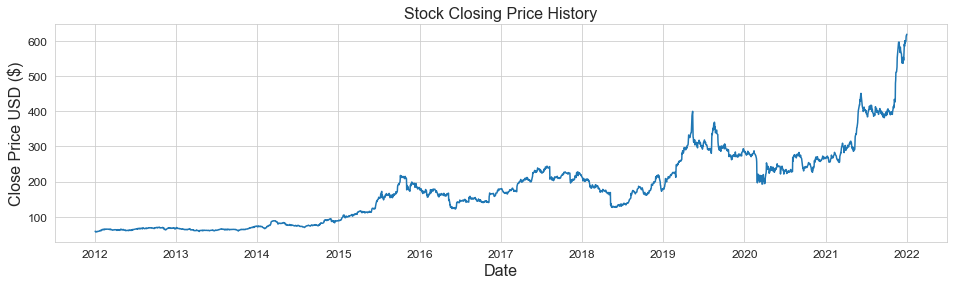

In [7]:
### Plot closing price history
sns.set_style('whitegrid') # Set plot styles for all plots.

plt.figure(figsize = (16, 4))
plt.plot(stock_df['Close'], label = 'Closing Price')
plt.title('Stock Closing Price History', fontsize = 16)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Close Price USD ($)', fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Stock Closing Price History.jpg', bbox_inches = 'tight', dpi = 1000)

In [8]:
### Generate moving average data
ma_days = [10, 30, 60]

for ma in ma_days:
    col_label = f'{ma}-day MA'
    stock_df2 = stock_df
    stock_df2[col_label] = stock_df2['Adj Close'].rolling(ma).mean()
    
stock_df2

,Open,High,Low,Close,Adj Close,Volume,Symbol,10-day MA,30-day MA,60-day MA
Date,,,,,,,,,,
2012-01-03,59.189999,59.189999,58.099998,58.599998,53.998177,37200,COKE,NaN,NaN,NaN
2012-01-04,58.400002,58.720001,57.639999,57.669998,53.141216,18500,COKE,NaN,NaN,NaN
2012-01-05,57.740002,58.369999,57.419998,57.779999,53.242561,8500,COKE,NaN,NaN,NaN
2012-01-06,57.759998,58.189999,56.730000,56.730000,52.275036,17400,COKE,NaN,NaN,NaN
2012-01-09,57.520000,57.520000,56.799999,57.139999,52.652832,12200,COKE,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,590.909973,602.140015,585.369995,599.650024,598.463135,21600,COKE,569.003577,561.242632,484.429925
2021-12-28,605.000000,619.150024,605.000000,612.020020,610.808716,23900,COKE,576.020667,564.606961,488.137651
2021-12-29,611.349976,625.000000,602.020020,616.000000,614.780762,19000,COKE,583.951929,568.066433,491.879660


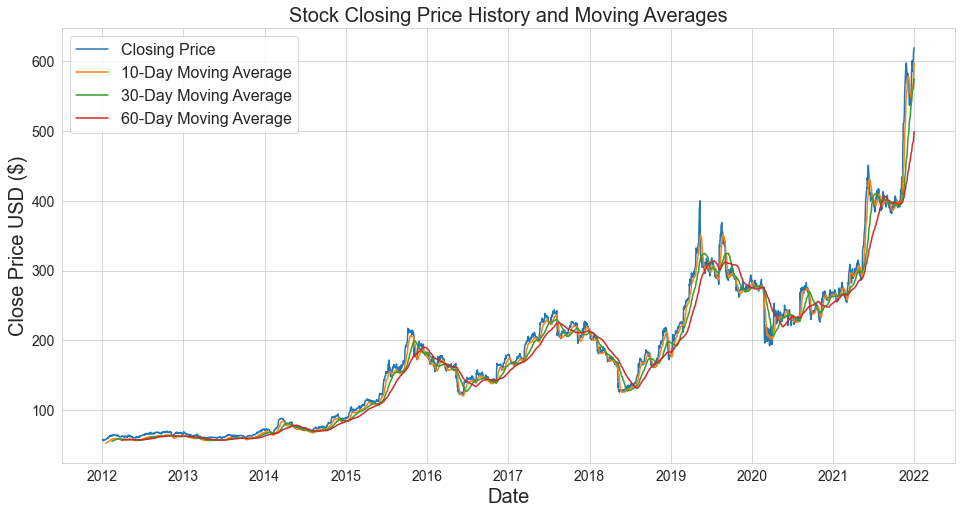

In [9]:
### Visualise moving average curves
plt.figure(figsize = (16, 8))
plt.plot(stock_df2['Close'], label = 'Closing Price')
plt.plot(stock_df2['10-day MA'], label = '10-Day Moving Average')
plt.plot(stock_df2['30-day MA'], label = '30-Day Moving Average')
plt.plot(stock_df2['60-day MA'], label = '60-Day Moving Average')
plt.title("Stock Closing Price History and Moving Averages", fontsize = 20)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Close Price USD ($)', fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize = 16)
plt.savefig('Closing Price History Moving Averages.jpg', bbox_inches = 'tight', dpi = 1000)

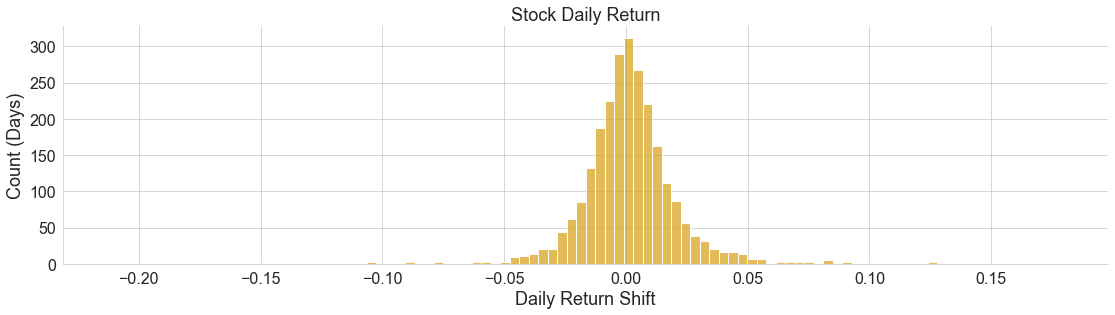

In [10]:
### Plot daily return - assess shape and spread of distribution
stock_df['Daily Return'] = stock_df['Adj Close'].pct_change()
sns.displot(stock_df['Daily Return'].dropna(), bins = 100, color = 'goldenrod', height = 4, aspect = 23/6)
plt.title("Stock Daily Return", fontsize = 18)
plt.xlabel('Daily Return Shift', fontsize = 18)
plt.ylabel('Count (Days)', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Stock Daily Return.jpg', bbox_inches = 'tight', dpi = 1000)

### Data preprocessing and splitting

Prior to beginning work with the Recurrent Neural Network (RNN) models, we must prepare our data. Below, we isolate the historic closing price data from which our model will learn. This data is then scaled between the range of 0-1 for application in the models. Subsequently, we split the data into training and test data. Tests were performed on the predictive sliding window size to gauge the effects on model prediction.

In [11]:
### Isolate the historic closing price values
data = stock_df.filter(['Close'])
dataset = data.values

In [12]:
### Scale features to range 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = scaler.fit_transform(dataset)

dataset_scaled

array([[0.00332468],
       [0.00167123],
       [0.0018668 ],
       ...,
       [0.99432848],
       [0.99592864],
       [1.        ]])

In [13]:
### Split into our training and test datasets, then set our sliding window!
train_len = int(np.ceil(len(dataset_scaled) * 0.8)) # EDIT TRAINING/TEST SPLIT HERE!
prediction_window = 10 # EDIT PREDICTION WINDOW SIZE HERE!

train_data = dataset_scaled[0:int(train_len), :]
test_data = dataset_scaled[train_len - prediction_window:, :]
X_train, y_train = [], []
X_test, y_test = [], dataset[train_len:, :]

for i in range(prediction_window, len(train_data)):
    X_train.append(train_data[i - prediction_window:i, 0])
    y_train.append(train_data[i, 0])
    
for i in range(prediction_window, len(test_data)):
    X_test.append(test_data[i - prediction_window:i, 0])

X_train, y_train, = np.array(X_train), np.array(y_train)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Training features shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Training features shape: (2004, 10, 1)
Training target shape: (2004,)
Test features shape: (503, 10, 1)
Test target shape: (503, 1)


### Model construction and experimentation
The RNN models were implemented using the 'keras' library. The implementation includes hyperparameter inputs to the Long Short-Term Memory (LSTM) layer(s) and fully connected layers applied in experimentation. Various model input parameters are assigned to variables as seen below. The model is then compiled and fit to the training data, before predictions are made on the test dataset and scaled back to the original stock price values.

**Please note:** Not all the experiments and their results are shown below. The experiments were conducted iteratively. After a test was conducted, the performance metrics were tabulated (as seen in the associated report), then model strucutre was modified/parameters were tuned to conduct the next test.

In [14]:
### Construct RNN model (EDIT MODEL STRUCTURE BELOW!)
model = Sequential()
#model.add(LSTM(128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#model.add(LSTM(64, return_sequences = False))
model.add(LSTM(64, return_sequences = False, input_shape = (X_train.shape[1], 1)))
#model.add(Dense(24))
model.add(Dense(1))

# TUNE MODEL HYPERPARAMETERS HERE!
optimizer = keras.optimizers.Adam(lr = 0.01) # EDIT MODEL OPTIMIZER AND LEARNING RATE HERE!
loss_fn = 'mean_squared_error' # EDIT MODEL LOSS FUNCTION HERE!
batch_size = 1 # EDIT MODEL BATCH SIZE HERE!
epochs = 5 # EDIT NUMBER OF MODEL EPOCHS HERE!

# Compile and fit model
model.summary()
model.compile(optimizer = optimizer, loss = loss_fn)
model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs)

# Make predictions! Remembering to scale back.
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2004/2004 [==============================] - 6s 2ms/step - loss: 4.7624e-04
Epoch 2/5
2004/2004 [==============================] - 5s 2ms/step - loss: 1.9654e-04
Epoch 3/5
2004/2004 [==============================] - 5s 2ms/step - loss: 1.8136e-04
Epoch 4/5
2004/2004 [==============================] - 5s 2ms/step - loss: 1.7865e-04
Epoch 5/5
16/16 [==============================] - 0s 2ms/step


### Performance evaluation
The performance of the RNN models was evaluated using the Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE) metrics. Both the RMSE and MAPE were calculated directly with assistance from the Numpy library.

Plots were then produced to assist visualise how the predictions compared to the target closing values. Overall, a high level of success was found when using the optimum RNN structure and hyperparameter values.

In [15]:
### Visualise some predicted versus known target prices
print("Predicted price ($USD) | Actual Price ($USD)")
for i in range(10):
    print("          ",y_pred[i],"|", y_test[i])

Predicted price ($USD) | Actual Price ($USD)
           [285.33218] | [282.01000977]
           [280.175] | [279.16000366]
           [277.367] | [277.26000977]
           [275.45706] | [276.45999146]
           [274.997] | [275.01998901]
           [273.50665] | [280.69000244]
           [281.14447] | [277.42999268]
           [275.9941] | [278.20001221]
           [277.57272] | [286.3500061]
           [287.65405] | [279.29998779]


In [16]:
### Calculate Performance Metrics: RMSE and MAPE
RMSE = np.sqrt(np.mean(((y_pred - y_test) ** 2)))
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Testing data results\n")
print(f'Root Mean Squared Error: ${(round(RMSE, 1))} USD')
print(f'Mean Absolute Percentage Error: {(round(MAPE, 1))}%')

Testing data results

Root Mean Squared Error: $8.1 USD
Mean Absolute Percentage Error: 1.8%


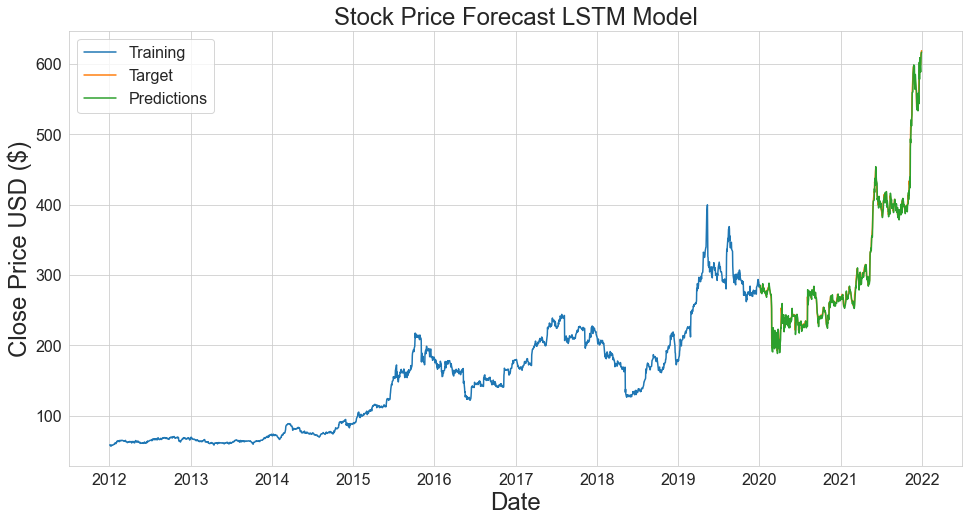

In [17]:
### Plot training data alongside validation and predictions
train = data[:train_len]
target = data[train_len:]
target['Predictions'] = y_pred

plt.figure(figsize = (16, 8))
plt.title('Stock Price Forecast LSTM Model', fontsize = 24)
plt.xlabel('Date', fontsize = 24)
plt.ylabel('Close Price USD ($)', fontsize = 24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(train['Close'])
plt.plot(target[['Close', 'Predictions']])
plt.legend(['Training', 'Target', 'Predictions'], loc = 'upper left', fontsize = 16)
plt.savefig('Stock Price Forecast LSTM Model.jpg', bbox_inches = 'tight', dpi = 1000)

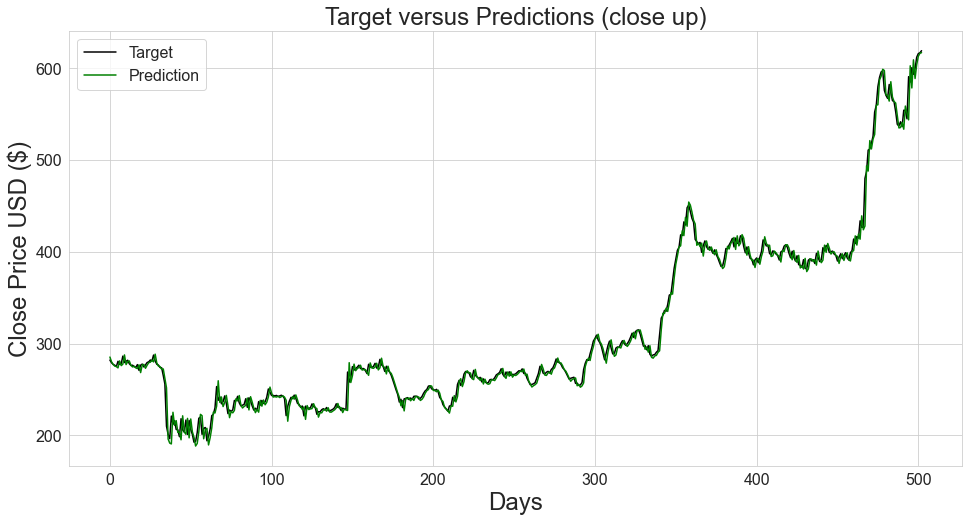

In [18]:
### View plot isolating target vs prediction data
plt.figure(figsize=(16,8))
plt.title('Target versus Predictions (close up)', fontsize = 24)
plt.xlabel('Days', fontsize = 24)
plt.ylabel('Close Price USD ($)', fontsize = 24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(y_test, color = 'black', label = 'Target')
plt.plot(y_pred, color = 'green', label = 'Prediction')
plt.legend(fontsize = 16)
plt.savefig('Target versus Predictions (close up).jpg', bbox_inches = 'tight', dpi = 1000)